# Homework 3

In [352]:
import numpy as np
import autograd
from time import process_time, perf_counter
import matplotlib.pyplot as plt

## Problem 2

In [353]:
# maps models to results
models = {}

# result indices
WEIGHTS = 0
COUNT = 1
ERRORS = 2

# Model IDs
CONSTANT_ALPHA = 1
DEC_ALPHA = 2
NORMALIZED_GRAD = 3
LIPSHITZ = 4
GOLDEN_SEARCH = 5
MOMENTUM = 6
REGULARIZATION = 7

model_name = {
    CONSTANT_ALPHA : "constant alpha",
    DEC_ALPHA : "Decreasing alpha with iteration",
    NORMALIZED_GRAD : "Normalized Gradient",
    LIPSHITZ : "lipshitz",
    GOLDEN_SEARCH : "golden search",
    MOMENTUM : "momentum",
    REGULARIZATION : "regularization"
}

In [354]:

def f(w):
    a = 20
    b = np.array([[-1], [1]])
    c = np.array([[2, 0 ], [1, 1]])
    return a + b.T @ w + w.T @ c @ w

def df_dw(w):
    b = np.array([[-1], [1]])
    c = np.array([[2, 0 ], [1, 1]])
    return b + (c + c.T) @ w


def grad_descent(grad, w, alpha=0.08, iterations=1000, tol=1e-6):
    tbeg = perf_counter()
    count = 0
    errors = []
    updatew = 1

    while (count < iterations and updatew > tol):
        Dg = grad(w)
        absDg = np.linalg.norm(Dg)
    
        lr = alpha
        w = w - lr * Dg
        updatew = absDg*lr
        errors.append(updatew)
        count += 1

    tend = perf_counter()
    dtime = (tend - tbeg) * 1000  # ms


    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors


w0 = np.array([-0.3,0.2]).reshape(2,1)

print(f"f(w) evaluated at w = [-0.3, 0.2] {f(w0)}")
print(f"derivative of f(w) at w = [-0.3, 0.2]:\n {df_dw(w0)}")

results = grad_descent(df_dw, w0, alpha=0.3, iterations=1000)
models[CONSTANT_ALPHA] = results


f(w) evaluated at w = [-0.3, 0.2] [[20.66]]
derivative of f(w) at w = [-0.3, 0.2]:
 [[-2. ]
 [ 1.1]]
Gradient Descent: 22 iterations
Time taken: 0.285 ms, Time per iteration: 0.013 ms
Final w: [ 0.42857114 -0.71428501]
Final f(w): [[19.42857143]]


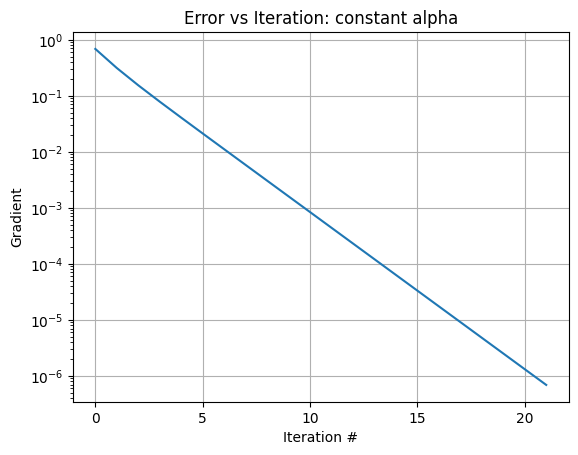

In [355]:
def plot_model_errors(model_id):
    plt.plot(models[model_id][ERRORS])
    plt.xlabel('Iteration #')
    plt.ylabel('Gradient')
    plt.title(f'Error vs Iteration: {model_name[model_id]}')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

plot_model_errors(CONSTANT_ALPHA)

Gradient Descent: 160 iterations
Time taken: 2.800 ms, Time per iteration: 0.018 ms
Final w: [ 0.42860916 -0.7143768 ]
Final f(w): [[19.42857144]]


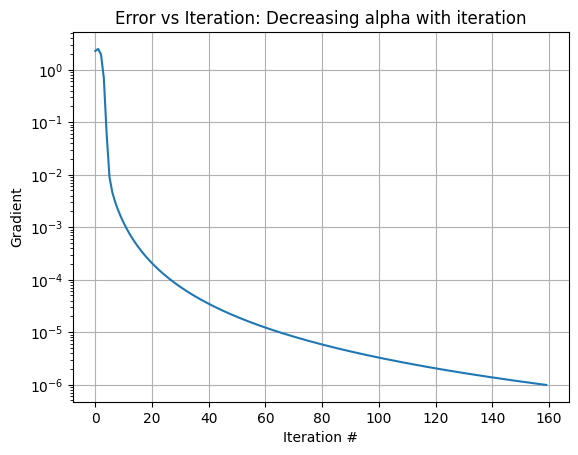

In [356]:
def grad_descent_dec_lr(grad, w, alpha=1.0, iterations=1000, tol=1e-6):
    tbeg = perf_counter()
    count = 0
    errors = []
    updatew = 1

    while (count < iterations and updatew > tol):
        Dg = grad(w)
        absDg = np.linalg.norm(Dg)
    
        lr = alpha / (count + 1)
        w = w - lr * Dg
        updatew = absDg*lr
        errors.append(updatew)
        count += 1

    tend = perf_counter()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

results = grad_descent_dec_lr(df_dw, w0, iterations=1000)
models[DEC_ALPHA] = results

plot_model_errors(DEC_ALPHA)

Gradient Descent: 1000000 iterations
Time taken: 12053.506 ms, Time per iteration: 0.012 ms
Final w: [ 0.35105246 -0.53372652]
Final f(w): [[19.45919467]]


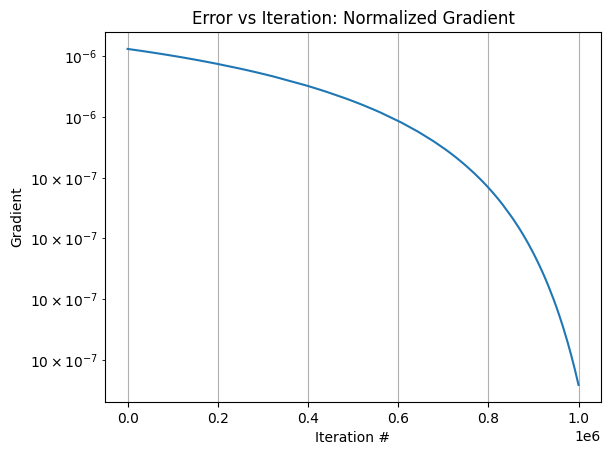

In [357]:
def grad_descent_dec_normalized(grad, w, alpha=1e-6, iterations=1000000, tol=1e-8):
    tbeg = perf_counter()
    count = 0
    errors = []
    updatew = 1
    epsilon = 1e-8
    while (count < iterations and updatew > tol):
        Dg = grad(w)
        absDg = np.linalg.norm(Dg)
    
        lr = alpha
        w = w - lr * Dg / (absDg + epsilon)
        updatew = (absDg / (absDg + epsilon)) * lr # magnitude of update in w
        errors.append(updatew)
        count += 1

    tend = perf_counter()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

results = grad_descent_dec_normalized(df_dw, w0)
models[NORMALIZED_GRAD] = results

plot_model_errors(NORMALIZED_GRAD)

Gradient Descent: 31 iterations
Time taken: 0.000 ms, Time per iteration: 0.000 ms
Final w: [ 0.42857099 -0.71428466]
Final f(w): [[19.42857143]]


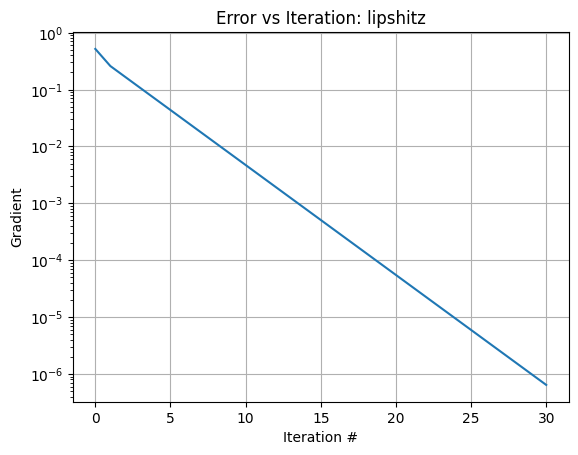

In [358]:

def compute_Lipschitz_constant():
    C = np.array([[2, 0], [1, 1]])
    A = C + C.T  
    lambda_vals = np.linalg.eigvalsh(A) 
    L = np.max(lambda_vals)
    return L

def grad_descent_dec_lipschitz(grad, w, alpha=1.0, iterations=1000, tol=1e-6):
    tbeg = process_time()
    count = 0
    errors = []
    updatew = 1
    L = compute_Lipschitz_constant()

    while (count < iterations and updatew > tol):
        Dg = grad(w)
        absDg = np.linalg.norm(Dg)
    
        lr = alpha / L
        w = w - lr * Dg
        updatew = np.linalg.norm(absDg*lr)
        errors.append(updatew)
        count += 1

    tend = process_time()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

results = grad_descent_dec_lipschitz(df_dw, w0, iterations=1000)
models[LIPSHITZ] = results

plot_model_errors(LIPSHITZ)

Gradient Descent: 19 iterations
Time taken: 0.000 ms, Time per iteration: 0.000 ms
Final w: [ 0.42857171 -0.71428575]
Final f(w): [[19.42857143]]


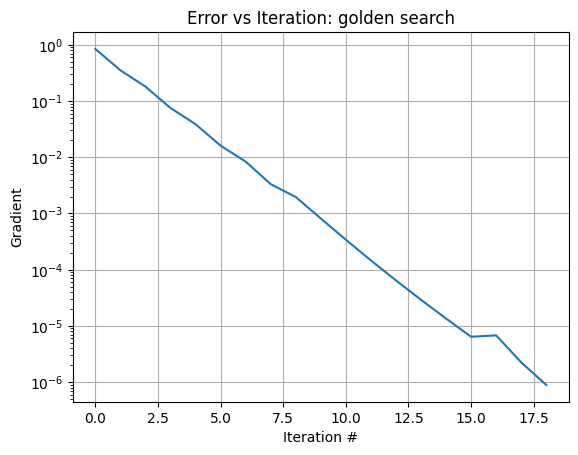

In [359]:
z = (1.0 + np.sqrt(5.0)) / 2.0

def goldendelta(x4, x1, z):
    return (x4 - x1) / z

def goldensearch(g, w, h, x1, x4, accuracy):
    x2 = x4 - goldendelta(x4, x1, z)
    x3 = x1 + goldendelta(x4, x1, z)
    
    f1 = g(w - x1 * h)
    f2 = g(w - x2 * h)
    f3 = g(w - x3 * h)
    f4 = g(w - x4 * h)

    i = 0
    error = abs(x4 - x1)
    
    while error > accuracy:
        if f2 < f3:
            x4, f4 = x3, f3
            x3, f3 = x2, f2
            x2 = x4 - goldendelta(x4, x1, z)
            f2 = g(w - x2 * h)
        else:
            x1, f1 = x2, f2
            x2, f2 = x3, f3
            x3 = x1 + goldendelta(x4, x1, z)
            f3 = g(w - x3 * h)
        
        i += 1
        error = abs(f4 - f1)
    
    alpha_star = (x1 + x4) / 2.0
    return alpha_star, i, error

def golden(g, w, h, alpha):
    alpha_star, i, err = goldensearch(g, w, h, alpha/10.0, alpha*10.0, 1e-6)
    return alpha_star

def grad_descent_golden_search(grad, w, alpha=0.1, iterations=1000, tol=1e-6):
    tbeg = process_time()
    count = 0
    errors = []
    updatew = 1

    while (count < iterations and updatew > tol):
        Dg = grad(w)
        absDg = np.linalg.norm(Dg)

        lr = golden(f, w, Dg, alpha)
        w = w - lr * Dg
        updatew = absDg * lr
        errors.append(updatew)
        count += 1

    tend = process_time()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

results = grad_descent_golden_search(df_dw, w0)
models[GOLDEN_SEARCH] = results

plot_model_errors(GOLDEN_SEARCH)


Gradient Descent: 36 iterations
Time taken: 6.557 ms, Time per iteration: 0.182 ms
Final w: [ 0.42857105 -0.71428418]
Final f(w): [[19.42857143]]


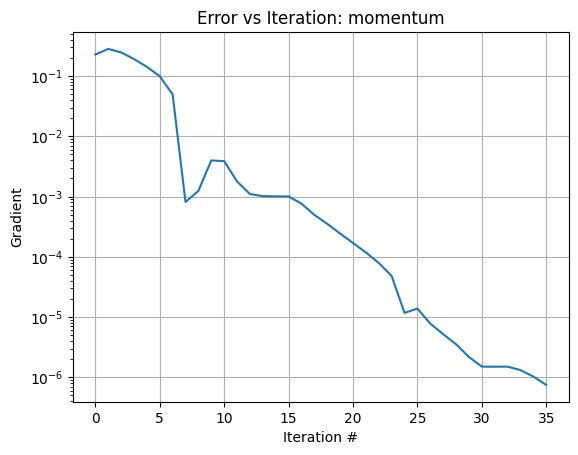

In [360]:
def grad_descent_momentum(grad, w, alpha=0.02, beta=0.5, iterations=1000, tol=1e-6):
    tbeg = perf_counter()
    count = 0
    errors = []
    updatew = 1
    h = np.zeros_like(w)

    while (count < iterations and updatew > tol):
        Dg = grad(w)

        h = beta * h + (1 - beta) * Dg
        lr = golden(f, w, h, alpha)
        w = w - lr * h
        updatew = np.linalg.norm(h) * lr
        errors.append(updatew)
        count += 1

    tend = perf_counter()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

results = grad_descent_momentum(df_dw, w0)
models[MOMENTUM] = results

plot_model_errors(MOMENTUM)


Gradient Descent: 19 iterations
Time taken: 0.437 ms, Time per iteration: 0.023 ms
Final w: [ 0.28571398 -0.4285707 ]
Final f(w): [[19.51020448]]


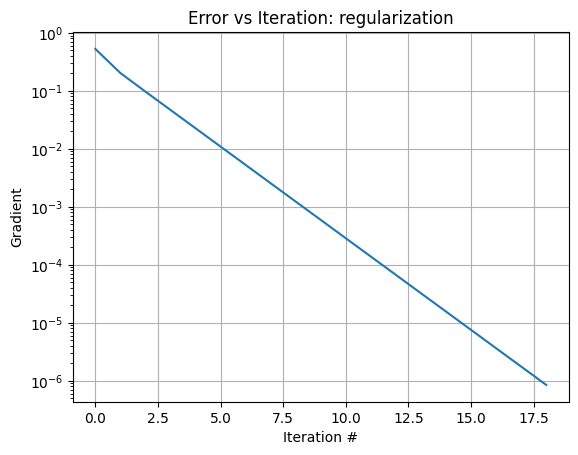

In [361]:
def grad_descent_regularization(grad, w, alpha=0.2, lamb=0.5, iterations=1000, tol=1e-6):
    tbeg = perf_counter()
    count = 0
    errors = []
    updatew = 1

    while (count < iterations and updatew > tol):
        Dg = grad(w, lamb)
        absDg = np.linalg.norm(Dg)

        lr = alpha
        w = w - lr * Dg
        updatew = absDg * lr
        errors.append(updatew)
        count += 1

    tend = perf_counter()
    dtime = (tend - tbeg) * 1000  # ms

    print(f'Gradient Descent: {count} iterations')
    print(f'Time taken: {dtime:.3f} ms, Time per iteration: {dtime/count:.3f} ms')
    print(f'Final w: {w.flatten()}')
    print(f'Final f(w): {f(w)}')

    return w, count, errors

def df_dw_reg(w, lamb):
    return df_dw(w) + 2 * lamb * w

results = grad_descent_regularization(df_dw_reg, w0)
models[REGULARIZATION] = results

plot_model_errors(REGULARIZATION)
